In [155]:
import dkistpkg_ct as DKISTanalysis
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch

import sunpy.coordinates
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
import tol_colors

from astropy.io import fits
from datetime import datetime
from datetime import time

muted = DKISTanalysis.color_muted2()

In [130]:
#VBI
path_vbi = '/Volumes/VBI_External/pid_2_11/'
folder1_vbi = 'AKDKX'
#folder2_vbi = 'BYMOL'
dir_list2_vbi = DKISTanalysis.pathdef(path_vbi,folder1_vbi)


In [131]:
dir_list2_vbi

['VBI_2024_08_11T22_23_34_333333_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_37_000000_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_39_666666_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_42_333333_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_45_000000_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_47_666666_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_50_333333_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_53_000000_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_55_666666_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_23_58_333333_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_24_01_000000_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_24_03_666666_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_24_06_333333_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_24_09_000000_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_24_11_666666_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_24_14_333333_00656282_I_AKDKX_L1.fits',
 'VBI_2024_08_11T22_24_17_000000_0065628

In [169]:
starttime = 150
endtime = 450

In [173]:
import matplotlib.dates as mdates
#get times (just from the filename...)
times=[]
for i in range(len(dir_list2_vbi)):
    times.append(time(int(dir_list2_vbi[i][15:17]),int(dir_list2_vbi[i][18:20]),int(dir_list2_vbi[i][21:23])))


In [174]:
times = times[200:450]

In [159]:
vbi_X, vbi_Y, hdul1_vbi, dat0_vbi = DKISTanalysis.vbi_process(path_vbi,
                                                              folder1_vbi)
#just pixels
vbix0 = np.arange(4096)
vbiy0 = np.arange(4096)
vbiX0,vbiY0= np.meshgrid(vbix0,vbiy0)

In [160]:
# load the destretched dataset...
filename = '/Users/coletamburri/Desktop/DKIST_Code/VBI_Destretching/AKDKX/postdestretch_dataCubeFlareImpulsivePhase.fits'

In [161]:
vbi_DS = fits.open(filename)

In [162]:
vbi_DS

In [163]:
np.shape(vbi_DS[0].data)
vbi_DSimgs = vbi_DS[0].data

In [172]:
np.shape(vbi_DSimgs)

(250, 4095, 4095)

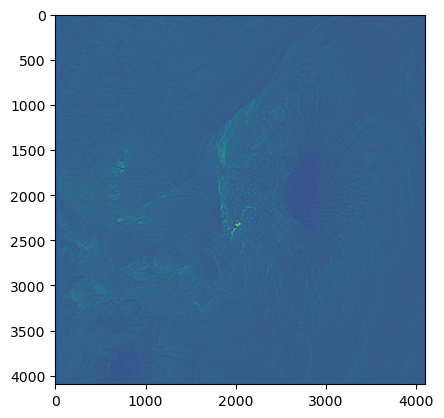

In [164]:
fig,ax=plt.subplots()
ax.imshow(vbi_DS[0].data[40,:,:])

In [139]:
#create cumulative mask? 
mask = np.zeros(np.shape(vbi_DSimgs))
timing = np.zeros(np.shape(vbi_DSimgs)[1:3])

l=0
for i in range(100):
    l+=1
    if i>0:
        mask[i,:,:]=mask[i-1,:,:]
    maskvals = np.nonzero((vbi_DSimgs[i,:,:]>3.8*np.median(vbi_DSimgs[i,:,:])))
    for j in range(np.shape(maskvals)[1]):
        #mask[i,maskvals[0][j],maskvals[1][j]] += vbi_DSimgs[i,maskvals[0][j],maskvals[1][j]]
        mask[i,maskvals[0][j],maskvals[1][j]] += 1
        #logic for timing array
        if timing[maskvals[0][j],maskvals[1][j]]==0:
            timing[maskvals[0][j],maskvals[1][j]]=l

In [140]:
for i in range(np.shape(timing)[0]):
    for j in range(np.shape(timing)[1]):
        if timing[i,j]==0:
            timing[i,j]='NaN'

[]

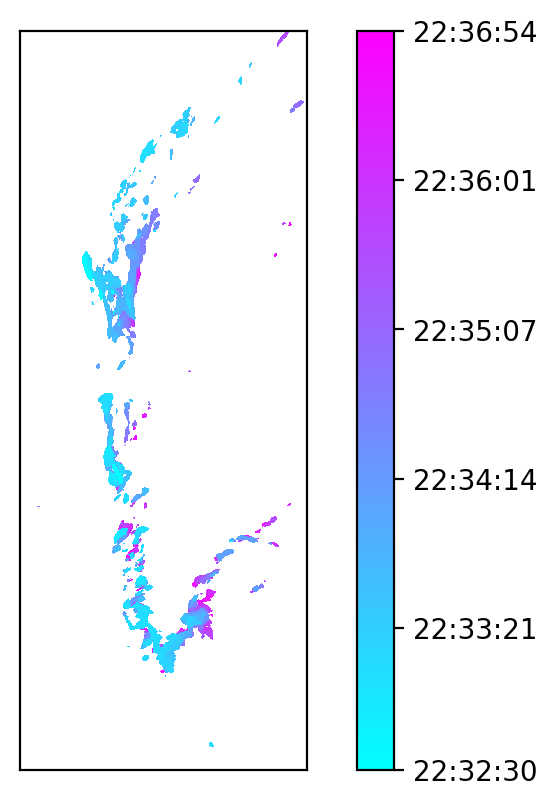

In [177]:
fig,ax=plt.subplots(dpi=200)
pcm=ax.pcolormesh(timing,cmap='cool')
ax.set_xlim([1600,2300])
ax.set_ylim([2700,900])
ax.set_aspect('equal')
cbar = fig.colorbar(pcm, ax=ax,ticks=[1,20,40,60,80,100])
cbar.ax.set_yticklabels([times[1],times[20],times[40],times[60],times[80],times[100]])
ax.set_xticks([])
ax.set_yticks([])

In [109]:
np.nanmax(timing)

np.float64(100.0)

(2600.0, 1200.0)

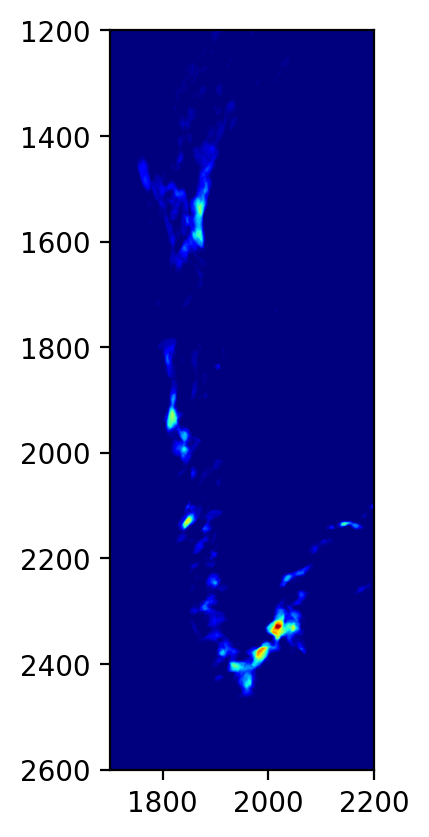

In [97]:
fig,ax=plt.subplots(dpi=200)
ax.imshow(mask[99,:,:],cmap='jet')
ax.set_xlim([1700,2200])
ax.set_ylim([2600,1200])

In [25]:
xlow = 1700
xhigh = 2350
ylow = 1000
yhigh = 2800

In [26]:
#indices for light curves are in last cumulative mask
i_vals = []
j_vals = []

final_mask = mask[119,:,:]

for i in range(np.shape(final_mask)[0]):
    for j in range(np.shape(final_mask)[1]):
        if final_mask[i,j] > 0.0 and j>xlow and j<xhigh and i>ylow and i<yhigh:
            i_vals.append(i)
            j_vals.append(j)

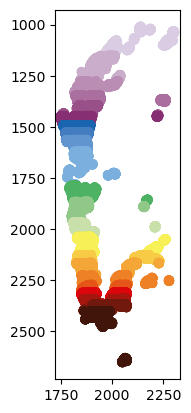

In [32]:
numcolor = len(j_vals)
maps = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=numcolor)
cmap_choice2 = maps(np.linspace(0,1,numcolor))
fig,ax=plt.subplots(dpi=100)
ax.scatter(j_vals,i_vals,c=cmap_choice2)
ax.invert_yaxis()
ax.set_aspect('equal')

In [37]:
fig,ax=plt.subplots()
for i in np.arange(1000,3000):
    ax.plot(vbi_DSimgs[0:119,i_vals[i],j_vals[i]],c=cmap_choice2[i],alpha=0.2)

np.float32(-10731.268)

In [66]:
i

np.int64(41926)

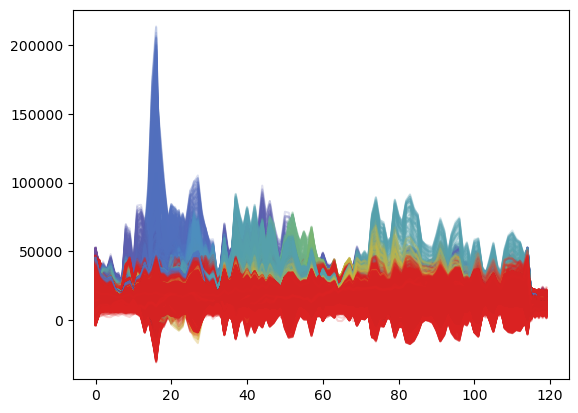

In [74]:
numcolor_timing = int(np.max(timing))
maps = tol_colors.tol_cmap(colormap='rainbow_PuRd',lut=numcolor_timing)
cmap_choice2 = maps(np.linspace(0,1,numcolor_timing))

fig,ax=plt.subplots()
for i in np.arange(len(i_vals)):
    ax.plot(vbi_DSimgs[0:120,j_vals[i],i_vals[i]],c=cmap_choice2[int(timing[j_vals[i],i_vals[i]])-1],alpha=0.2)

In [70]:
#overall light curve - within region
lc=[]

for i in range(250):
    lc.append(np.sum(vbi_DSimgs[i,ylow:yhigh,xlow:xhigh]))

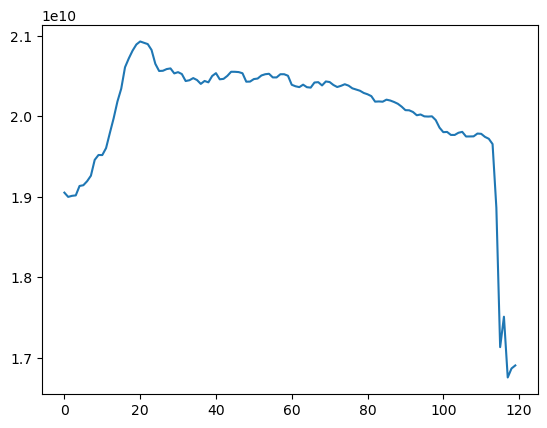

In [72]:
plt.plot(lc[0:120])

In [ ]:
fig,ax=plt.subplots();
for i in range(xlow,xhigh):
    for j in range(ylow,yhigh):
        ax.plot(vbi_DSimgs[:,i,j])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1070fe610>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/spyder/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [12]:
range(xlow,xhigh)

range(1500, 2500)